# explore the extended kalman filter data

````
Data Flow:
1) The measuremennt processor/matlab simulator is generating the FUSION .txt file:
	"data/obj_pose-laser-radar-synthetic-ukf-input.txt";
	OR
	"../matlab_examples/obj_pose-laser-radar-synthetic-ukf-input.txt";

The Input file format is:
#L(for laser) meas_px meas_py timestamp gt_px gt_py gt_vx gt_vy
#R(for radar) meas_rho meas_phi meas_rho_dot timestamp gt_px gt_py gt_vx gt_vy

Example:
R	8.60363	0.0290616	-2.99903	1477010443399637	8.6	0.25	-3.00029	0
L	8.45	0.25	1477010443349642	8.45	0.25	-3.00027	0
	
2) The EKF Algorithm reads form file reads all the lines and generates measurement structures
3) The MeasurementProcessor() is called with individual measurements (one by one). The results are saved
(Attention: no file processing routines are used inside MeasurementProcessor() all the file processing routines are in the main function
So the data read/write is decoupled from the algorithm
4) The results are saved in an output file:
"data/obj_pose-laser-radar-ekf-output.txt"

Output file format:
est_px est_py est_vx est_vy meas_px meas_py gt_px gt_py gt_vx gt_vy

Example:
4.53271	0.279	-0.842172	53.1339	4.29136	0.215312	2.28434	0.226323
43.2222	2.65959	0.931181	23.2469	4.29136	0.215312	2.28434	0.226323
````

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import datetime
import math
import random
import csv

%matplotlib inline

In [2]:
raw_data = []
with open('data/data-1.txt', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        raw_data.append(row)

In [3]:
def polar_to_cartesian(polar_x):
    rho, phi, drho = polar_x[0], polar_x[1], polar_x[2]
    
    px = rho * math.cos(phi)
    py = rho * math.sin(phi)
    vx = drho * math.cos(phi)
    vy = drho * math.sin(phi)
    
    return np.array([px, py, vx, vy])
    

In [4]:
def cartesian_to_polar(cartesian_x_):
    THRESH = 0.0001;
    cartesian_x = cartesian_x_.flatten()
    px, py, vx, vy = cartesian_x[0], cartesian_x[1], cartesian_x[2], cartesian_x[3]
    rho = math.sqrt(px**2 + py**2)
    phi = math.atan2(py, px)
    drho = 0
    if rho > THRESH: drho = (px*vx + py*vy) / rho
    
    return np.array([rho, phi, drho])

In [5]:
def get_jacobian_from_state(cartesian_x_):
    cartesian_x = cartesian_x_.flatten()
    px, py, vx, vy = cartesian_x[0], cartesian_x[1], cartesian_x[2], cartesian_x[3]
    
    
    px2_plus_py2 = px**2 + py**2
    on_sqrt = math.sqrt(px2_plus_py2)
    on_3_per_2 = math.pow(px2_plus_py2, 3/2)
    
    vi1 = py * (vx*py - vy*px) / on_3_per_2
    vi2 = px * (vy*px - vx*py) / on_3_per_2
    
    Hj = np.array([[px / on_sqrt,        py / on_sqrt,      0,             0]
                  ,[-py / px2_plus_py2,  px / px2_plus_py2, 0,             0]
                  ,[vi1,                 vi2,               px / on_sqrt,  py / on_sqrt ]
                  ])
    return Hj
    
    

In [6]:
class Kalman():
    def __init__(self):
        self.x = np.array([[0], 
                           [0],
                           [0],
                           [0]]) # initial state (location and velocity)
        self.inited = False
        self.reset()
        
    def reset(self):
        self.P = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0],
                           [0, 0, 1000, 0], 
                           [0, 0, 0, 1000]]).astype(float) # initial uncertainty
        
        self.u = np.array([[0], [0], [0], [0]]) # external motion
        
        self.F = np.array([[1, 0, 1, 0], 
                           [0, 1, 0, 1],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]]).astype(float) # next state function
               
        self.I = np.array([[1, 0, 0, 0], 
                           [0, 1, 0, 0],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]]) # identity matrix      
        
    def start(self, x_):
        x__ = np.array(x_).reshape(4,1)    
        self.x = x__
        print (x__, self.x)
        self.inited = True
        
    def feed_meas_L(self, measurement): 
        #print('------ L ---------')
        if (self.inited == False):
            self.start(measurement)
            return
        
        z = np.array(measurement).reshape((2,-1)) # z - measurement matrix
        H = np.array([[1, 0, 0, 0] # X to measurement mapping matrix (H * x = measurement)
                     ,[0, 1, 0, 0]])
        R = np.array([[0.01, 0], 
                     [0, 0.01]])
        
        Hx = H.dot(self.x)
    
        self.process_meas(z, H, Hx, R)
        

    def feed_meas_R(self, measurement):
        #print('------ R ---------')
        if (self.inited == False):
            self.start(polar_to_cartesian(measurement))
            return
        
        z = np.array(measurement).reshape((3,-1)) # z - measurement matrix
        H = get_jacobian_from_state(polar_to_cartesian(measurement))
        R =  np.array([[0.01, 0, 0], 
                     [0, 1.0e-6, 0], 
                     [0, 0, 0.01]])
        
        Hx = cartesian_to_polar(self.x).reshape(3,1)
        
        self.process_meas(z, H, Hx, R)

    def process_meas(self, z, H, Hx, R):

        y = z - Hx # error : previous state - measurement X measurement matrix
        #print ('z', z)
        #print ('y', y)
        S = H.dot(self.P).dot(H.transpose()) + R
        #print ('S', S)
        K = self.P.dot(H.transpose()).dot(np.linalg.inv(S)) # kalman gain
        #print('K', K)
        self.x = self.x + K.dot(y) # new state : x + kalman gain X error
        #print ('self.x', self.x)
        self.P = np.dot((self.I - K.dot(H)), self.P) # + self.Q # adjusting uncertainty covaria       
        #print ('self.P', self.P)
        
    def predict_next_state(self): 
        self.x = np.dot(self.F, self.x) #+ self.u # new state : movement matrix X current state + movement
        self.P = np.dot(np.dot(self.F, self.P), self.F.transpose()) + self.Q # adjusting covar matrix
       
    def update_F(self, dt):
        self.F[0, 2] = dt;
        self.F[1, 3] = dt; 
        
    def update_Q(self, dt):
        ##### covariance uncertainity Q
        ##### values coming from decomposing the acceleration component in the kin.equatations

        dt2 = dt * dt
        dt3 = dt * dt2
        dt4 = dt * dt3

        x, y = 5,5

        r11 = dt4 * x / 4
        r13 = dt3 * x / 2
        r22 = dt4 * y / 4
        r24 = dt3 * y /  2
        r31 = dt3 * x / 2 
        r33 = dt2 * x
        r42 = dt3 * y / 2
        r44 = dt2 * y

        self.Q = np.array([[r11, 0, r13, 0],
                      [0, r22, 0, r24],
                      [r31, 0, r33, 0], 
                      [0, r42, 0, r44]])    
    
    
        
        
def calculate_RMSE(truth_, pred_):
    truth = np.array(truth_).reshape(-1,4).astype(float)   
    pred = np.array(pred_).reshape(-1,4).astype(float)
    
    truth = truth[:,0:2]
    pred = pred[:,0:2]
    return np.sqrt(np.sum((truth - pred)**2, axis=1))




pred_list = []
l_meas_list = []
r_meas_list = []
truth_list = []
i = 1
k = Kalman()
timestamp = 0
for c,p in enumerate(raw_data):
    i += 1
    if p[0] == 'L':
        ## lidar
        x, y = float(p[1]), float(p[2])
        dt = (int(p[3]) - timestamp) / 100000        
        #dt += random.random() / 10 - 0.05
        timestamp = int(p[3])

        k.update_Q(dt)
        k.update_F(dt)
        k.predict_next_state()
        k.feed_meas_L([x,y])
        
        l_meas_list.append([x,y])
        
        pred_list.append(k.x)
        truth_list.append(p[4:8])
        
        
        
        
        ####################
        ####################
        print("-----------------------------------------------------------")
        print("#", c+1, ":", int(p[3]))
        print("-----------------------------------------------------------")   
        print('{:15s} | {:8.3f} | {:8.3f} |'.format("LIDAR:", x, y))
        pred_flat = k.x.flatten()
        print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'
              .format("PREDICTION:",pred_flat[0], pred_flat[1], pred_flat[2], pred_flat[3] ))
        print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("TRUTH:",float(p[4]), float(p[5]),float(p[6]), float(p[7])))  
        
    else:
        #continue
        ## radar
        rho, phi, drho = float(p[1]), float(p[2]), float(p[3])
        dt = (int(p[4]) - timestamp) / 100000
        
        dt += random.random() / 10 - 0.05

        timestamp = int(p[4])
        
        k.update_Q(dt)
        k.update_F(dt)
        k.predict_next_state()        
        cartesian = polar_to_cartesian([rho, phi, drho])
        #k.feed_meas_L([cartesian[0], cartesian[1]])
        k.feed_meas_R([rho, phi, drho])
                        
        r_meas_list.append(polar_to_cartesian([rho, phi, drho]))
        
        pred_list.append(k.x)
        truth_list.append(p[5:9])

        ####################
        ####################
        print("-----------------------------------------------------------")
        print("#", c+1, ":", int(p[4]))
        print("-----------------------------------------------------------")   
        print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} |'.format('RADAR', rho, phi, drho))
        pred_flat = k.x.flatten()
        print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'
              .format("PREDICTION:",pred_flat[0], pred_flat[1], pred_flat[2], pred_flat[3] ))
        print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("TRUTH:",float(p[5]), float(p[6]),float(p[7]), float(p[8])))  
        
      
        


pred_list = np.array(pred_list)
l_meas_list = np.array(l_meas_list)
r_meas_list = np.array(r_meas_list)
truth_list = np.array(truth_list)

RMSE = calculate_RMSE(truth_list, pred_list)
print ('RMSE', np.sum(RMSE) / len(RMSE))

[[ 8.46291875]
 [ 0.24346237]
 [-3.03909268]
 [-0.08742902]] [[ 8.46291875]
 [ 0.24346237]
 [-3.03909268]
 [-0.08742902]]
-----------------------------------------------------------
# 1 : 1477010443399637
-----------------------------------------------------------
RADAR           |    8.466 |    0.029 |   -3.040 |
PREDICTION:     |    8.463 |    0.243 |   -3.039 |   -0.087 |
TRUTH:          |    8.600 |    0.250 |   -3.000 |    0.000 |
-----------------------------------------------------------
# 2 : 1477010443449633
-----------------------------------------------------------
LIDAR:          |    8.448 |    0.252 |
PREDICTION:     |    8.448 |    0.252 |   -3.039 |   -0.087 |
TRUTH:          |    8.450 |    0.250 |   -3.000 |    0.000 |
-----------------------------------------------------------
# 3 : 1477010443499690
-----------------------------------------------------------
RADAR           |    8.571 |    0.028 |   -0.011 |
PREDICTION:     |    8.548 |    0.239 |   -0.001 |   -0.034

-----------------------------------------------------------
# 58 : 1477010446439730
-----------------------------------------------------------
LIDAR:          |    7.957 |   -6.243 |
PREDICTION:     |    8.096 |   -6.348 |   -1.706 |    1.145 |
TRUTH:          |    7.950 |   -6.250 |    1.999 |   -2.998 |
-----------------------------------------------------------
# 59 : 1477010446494754
-----------------------------------------------------------
RADAR           |   10.410 |   -0.668 |    2.532 |
PREDICTION:     |    8.222 |   -6.476 |    1.948 |   -1.542 |
TRUTH:          |    8.050 |   -6.350 |    1.817 |   -1.817 |
-----------------------------------------------------------
# 60 : 1477010446549779
-----------------------------------------------------------
LIDAR:          |    8.159 |   -6.453 |
PREDICTION:     |    8.242 |   -6.518 |   -1.569 |    1.169 |
TRUTH:          |    8.150 |   -6.450 |    1.817 |   -1.817 |
-----------------------------------------------------------
# 61 

TRUTH:          |   11.050 |   -0.950 |   -1.998 |    3.996 |
-----------------------------------------------------------
# 234 : 1477010455809746
-----------------------------------------------------------
LIDAR:          |   10.958 |   -0.729 |
PREDICTION:     |   10.834 |   -0.716 |    1.839 |    0.253 |
TRUTH:          |   10.950 |   -0.750 |   -1.998 |    3.996 |
-----------------------------------------------------------
# 235 : 1477010455864779
-----------------------------------------------------------
RADAR           |   10.881 |   -0.061 |   -1.033 |
PREDICTION:     |   10.866 |   -0.652 |   -1.017 |    0.100 |
TRUTH:          |   10.900 |   -0.650 |   -0.909 |    1.817 |
-----------------------------------------------------------
# 236 : 1477010455919813
-----------------------------------------------------------
LIDAR:          |   10.865 |   -0.553 |
PREDICTION:     |   10.824 |   -0.554 |    0.715 |    0.207 |
TRUTH:          |   10.850 |   -0.550 |   -0.909 |    1.817 |


# 407 : 1477010465049633
-----------------------------------------------------------
RADAR           |   10.419 |   -1.098 |   -2.336 |
PREDICTION:     |    4.716 |   -9.208 |   -0.831 |    2.147 |
TRUTH:          |    4.800 |   -9.400 |    1.000 |    3.000 |
-----------------------------------------------------------
# 408 : 1477010465099631
-----------------------------------------------------------
LIDAR:          |    4.845 |   -9.241 |
PREDICTION:     |    4.789 |   -9.129 |    0.924 |   -1.407 |
TRUTH:          |    4.850 |   -9.250 |    1.000 |    3.000 |
-----------------------------------------------------------
# 409 : 1477010465149630
-----------------------------------------------------------
RADAR           |   10.469 |   -1.074 |   -0.809 |
PREDICTION:     |    4.971 |   -9.185 |   -0.096 |    0.839 |
TRUTH:          |    4.950 |   -9.150 |    2.000 |    2.000 |
-----------------------------------------------------------
# 410 : 1477010465199629
--------------------------

# 574 : 1477010473849762
-----------------------------------------------------------
LIDAR:          |    8.951 |   -8.164 |
PREDICTION:     |    9.021 |   -8.224 |   -1.230 |    0.806 |
TRUTH:          |    8.950 |   -8.150 |    0.909 |   -2.727 |
-----------------------------------------------------------
# 575 : 1477010473904699
-----------------------------------------------------------
RADAR           |   12.228 |   -0.739 |    2.506 |
PREDICTION:     |    9.113 |   -8.297 |    1.885 |   -1.568 |
TRUTH:          |    9.050 |   -8.250 |    1.820 |   -1.820 |
-----------------------------------------------------------
# 576 : 1477010473959637
-----------------------------------------------------------
LIDAR:          |    9.151 |   -8.348 |
PREDICTION:     |    9.224 |   -8.409 |   -1.190 |    0.968 |
TRUTH:          |    9.150 |   -8.350 |    1.820 |   -1.820 |
-----------------------------------------------------------
# 577 : 1477010474009643
-------------------------------------

PREDICTION:     |   10.481 |   -0.353 |   -3.087 |    0.245 |
TRUTH:          |   10.700 |   -0.350 |   -2.995 |    1.997 |
-----------------------------------------------------------
# 738 : 1477010482679790
-----------------------------------------------------------
LIDAR:          |   10.553 |   -0.247 |
PREDICTION:     |   10.390 |   -0.244 |    2.116 |    0.176 |
TRUTH:          |   10.550 |   -0.250 |   -2.995 |    1.997 |
-----------------------------------------------------------
# 739 : 1477010482734821
-----------------------------------------------------------
RADAR           |   10.434 |   -0.019 |   -1.671 |
PREDICTION:     |   10.402 |   -0.189 |   -1.637 |    0.099 |
TRUTH:          |   10.450 |   -0.200 |   -1.817 |    0.909 |
-----------------------------------------------------------
# 740 : 1477010482789852
-----------------------------------------------------------
LIDAR:          |   10.351 |   -0.143 |
PREDICTION:     |   10.288 |   -0.142 |    0.998 |    0.068 |


# 905 : 1477010491694709
-----------------------------------------------------------
RADAR           |   10.511 |   -1.098 |   -1.955 |
PREDICTION:     |    4.752 |   -9.300 |   -0.649 |    1.817 |
TRUTH:          |    4.800 |   -9.400 |    0.908 |    2.724 |
-----------------------------------------------------------
# 906 : 1477010491749773
-----------------------------------------------------------
LIDAR:          |    4.875 |   -9.255 |
PREDICTION:     |    4.840 |   -9.185 |    0.846 |   -1.149 |
TRUTH:          |    4.850 |   -9.250 |    0.908 |    2.724 |
-----------------------------------------------------------
# 907 : 1477010491804763
-----------------------------------------------------------
RADAR           |   10.281 |   -1.071 |   -1.598 |
PREDICTION:     |    4.914 |   -9.008 |   -0.492 |    1.524 |
TRUTH:          |    4.950 |   -9.100 |    1.819 |    2.728 |
-----------------------------------------------------------
# 908 : 1477010491859753
--------------------------

TRUTH:          |    9.250 |   -8.650 |    0.909 |   -2.727 |
-----------------------------------------------------------
# 1077 : 1477010500744749
-----------------------------------------------------------
RADAR           |   12.613 |   -0.758 |    2.415 |
PREDICTION:     |    9.241 |   -8.746 |    1.603 |   -1.729 |
TRUTH:          |    9.300 |   -8.800 |    0.909 |   -2.728 |
-----------------------------------------------------------
# 1078 : 1477010500799727
-----------------------------------------------------------
LIDAR:          |    9.352 |   -8.951 |
PREDICTION:     |    9.409 |   -9.006 |   -0.794 |    0.583 |
TRUTH:          |    9.350 |   -8.950 |    0.909 |   -2.728 |
-----------------------------------------------------------
# 1079 : 1477010500849738
-----------------------------------------------------------
RADAR           |   13.195 |   -0.769 |    3.023 |
PREDICTION:     |    9.567 |   -9.265 |    2.027 |   -2.161 |
TRUTH:          |    9.400 |   -9.100 |    1.000

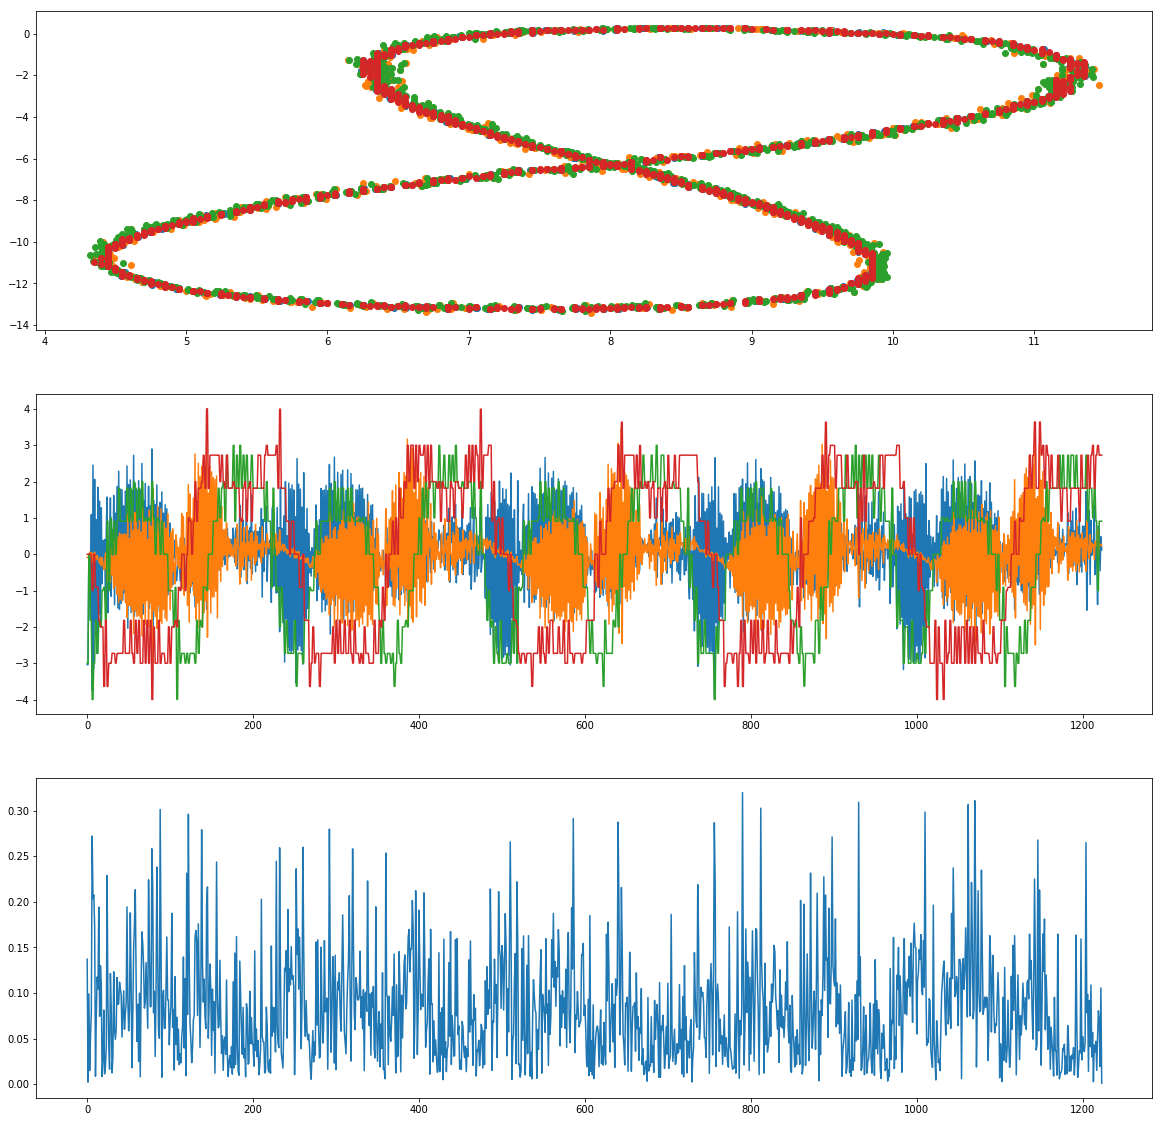

In [7]:
plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
plt.scatter(l_meas_list[:,0], l_meas_list[:,1])
plt.scatter(r_meas_list[:,0], r_meas_list[:,1])
plt.scatter(pred_list[:,0][:], pred_list[:,1][:])
plt.scatter(truth_list[:,0], truth_list[:,1])

plt.subplot(3,1,2)
plt.plot(pred_list[:,2])
plt.plot(pred_list[:,3])
plt.plot(truth_list[:,2])
plt.plot(truth_list[:,3])

plt.subplot(3,1,3)
plt.plot(RMSE)
